<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />


<h1>Preprocessing with Principle Component Analysis </h1>

<h2>Table of Contents</h2>
<p>This notebook contains neural networks trained to predict house prices in King County, Washington, USA based on features of the house. They are trained using different preprocessing methods like PCA and Standardization. They are also trained using different Neural Networks with one featuring batch normalization. We will explore the benefits of data preprocessing on our neural networks and how they affect performance.</p>

<ul>
    <li><a href="#UFI">Utility Functions and Imports </a></li>
    <li><a href="#MDC">Dataset Class   </a></li>
    <li><a href="#DNN"> Different Neural Networks and Function to Train Neural Network   </a></li>
    <li><a href="#tv">Training and Validating the Model </a></li>
</ul>

<p>Estimated Time Needed: <strong>20 min</strong></p>

<hr>


<h2 id="UFI">Utility Functions and Imports </h2>

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn import preprocessing
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Here we load the dataset we will use and the already trained models to save time instead of training from scratch.

In [2]:
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/king_county_house_data.csv
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/pca_model.pt
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/regular_model.pt
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/standardized_model.pt

--2023-10-10 16:01:33--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/king_county_house_data.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1930704 (1.8M) [text/csv]
Saving to: ‘king_county_house_data.csv’

king_county_house_d 100%[===================>]   1.84M  1.44MB/s    in 1.3s    

2023-10-10 16:01:36 (1.44 MB/s) - ‘king_county_house_data.csv’ saved [1930704/1930704]

--2023-10-10 16:01:36--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/pca_model.pt
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to s3.us.cloud-object-storage.appdomai

<h2 id="DSC">Dataset Class </h2>

Turn the csv into a dataframe:

In [3]:
df = pd.read_csv('king_county_house_data.csv')
print(df.shape)
df.head()

(21613, 19)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Create a PyTorch Dataset object to store our dataframe values in. We create 3 type of data: one for data with PCA, Standardization and regular data with no preprocessing.

In [4]:
class data(Dataset):
    
    def __init__(self, test=False, regular=False, pca=False, standard=False):
        
        X = df.drop(columns='price')
        Y = df['price']
        # Split the data into training data and testing data using a 80/20 split
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=1)
        
        x_train = x_train.astype(float)
        x_test = x_test.astype(float)
        
        if (regular):
            
            if (test):
                self.x = torch.FloatTensor(x_test.values)
                self.y = torch.FloatTensor(y_test.values).view(-1,1)
            else:
                self.x = torch.FloatTensor(x_train.values)
                self.y = torch.FloatTensor(y_train.values).view(-1,1)
                
        elif (pca):
            
            # Performs PCA on the data
            pca = PCA(whiten=True)
            x_train = pca.fit_transform(x_train)
            x_test = pca.transform(x_test)
            
            if (test):
                self.x = torch.FloatTensor(x_test)
                self.y = torch.FloatTensor(y_test.values).view(-1,1)
            else:
                self.x = torch.FloatTensor(x_train)
                self.y = torch.FloatTensor(y_train.values).view(-1,1)
                
        else:
            
            # Performs Standardization on the data
            standard = preprocessing.StandardScaler()
            x_train = standard.fit_transform(x_train)
            x_test = standard.transform(x_test)
            
            if (test):
                self.x = torch.FloatTensor(x_test)
                self.y = torch.FloatTensor(y_test.values).view(-1,1)
            else:
                self.x = torch.FloatTensor(x_train)
                self.y = torch.FloatTensor(y_train.values).view(-1,1)

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

<h2 id="DNN">Different Neural Networks and Function to Train Neural Networks </h2>

Here we define the Neural Networks we will use. They are both 4 layered networks with 1 input layer, 1 output layer, and 2 hidden layers. The number of nodes in each layer is 2/3 of the input layer except the output because we are doing regression. They both use relu as the activation function.

The difference is that one uses Batch Normalization and one does not.

In [5]:
class BatchNormalizationNN(nn.Module):
    
    # Constructor
    def __init__(self):
        super(BatchNormalizationNN, self).__init__()
        # The dataset has 18 features
        self.linear1 = nn.Linear(18, 12)
        self.b1 = nn.BatchNorm1d(12)
        self.linear2 = nn.Linear(12, 8)
        self.b2 = nn.BatchNorm1d(8)
        self.linear3 = nn.Linear(8, 1)

    # Prediction    
    def forward(self, x): 
        y = self.b1(torch.relu(self.linear1(x)))
        y = self.b2(torch.relu(self.linear2(y)))
        y = self.linear3(y)
        return y

In [6]:
class RegularNN(nn.Module):
    
    # Constructor
    def __init__(self):
        super(RegularNN, self).__init__()
        # The dataset has 18 features
        self.linear1 = nn.Linear(18, 12)
        self.linear2 = nn.Linear(12, 8)
        self.linear3 = nn.Linear(8, 1)

    # Prediction    
    def forward(self, x): 
        y = torch.relu(self.linear1(x)) 
        y = torch.relu(self.linear2(y))
        y = self.linear3(y)
        return y

Function `train` performs the training of the models. It is given the training data, testing data, criterion (loss function), model (Neural Network), optimizer, and epochs (number of times the model is trained on the entire dataset). 

In [7]:
def train(train_loader, test_loader, criterion, model, optimizer, epochs):
    
    train_loss = []
    test_loss = []
    
    for epoch in range(epochs):
        
        print(epoch)
        
        total_loss = 0
        
        for i, (x, y) in enumerate(train_loader):
            # Set the model in training mode so it updates values in Batch Normalization
            model.train()
            # Clears the optimizer
            optimizer.zero_grad()
            # Calculates the prediction the model gives
            z = model(x)
            # Calculates the loss between the prediction and the actual value
            loss = criterion(z, y)
            # Calcualates the partial deriviative for each parameter of the Neural Network
            loss.backward()
            # Adjusts the parameters according to the optimizer
            optimizer.step()
            total_loss = total_loss + loss.item()
        
        train_loss.append(total_loss/(len(train_loader.dataset)/train_loader.batch_size))
        print(total_loss/(len(train_loader.dataset)/train_loader.batch_size))
        
        total_loss = 0
        
        for i, (x, y) in enumerate(test_loader):
            # Set the model in evaluation mode so we do not train the Batch Normalization while evaluating our model
            model.eval()
            z = model(x)
            loss = criterion(z, y)
            total_loss = total_loss + loss.item()
        
        test_loss.append(total_loss/len(test_loader.dataset))
        print(total_loss/len(test_loader.dataset))
        
    return train_loss, test_loss

<h2 id="UFI">Training and Validating Model  </h2>

We have trained the model prior you can load them and use them to run you model.

Vanilla Neural network:

In [8]:
RegularModel = RegularNN()
checkpoint = torch.load('regular_model.pt')
RegularModel.load_state_dict(checkpoint['model_state_dict'])
RegularModel.eval()
regular_train_loss = checkpoint['train_loss']
regular_test_loss = checkpoint['test_loss']

Neural network with Batch Norm:

In [9]:
PCAModel = BatchNormalizationNN()
checkpoint = torch.load('pca_model.pt')
PCAModel.load_state_dict(checkpoint['model_state_dict'])
PCAModel.eval()
pca_train_loss = checkpoint['train_loss']
pca_test_loss = checkpoint['test_loss']

Neural network with Batch Norm  and Stardardizing the data:

In [10]:
StandardModel = BatchNormalizationNN()
checkpoint = torch.load('standardized_model.pt')
StandardModel.load_state_dict(checkpoint['model_state_dict'])
StandardModel.eval()
stan_train_loss = checkpoint['train_loss']
stan_test_loss = checkpoint['test_loss']

## Training

The code in the sections below is code to train the models with each type of preprocessing. The training code is saved a raw so it does not accidentally get run as it would take a lot of time to train. The loss function used is SmoothL1Loss and in its current setup it gives the absolute value of the error between the prediction and actual value. The optimizer used is Adadelta, we use this because we do not need to worry about initializing or updating the rate at which the Neural Network learns. If you would like to experiment with the Neural Networks, please change the type of the training block to code using the options at the top. 

## Regular Neural Network       

If you would like to train the model yourself, you can convert the following markdown cell to a code.   

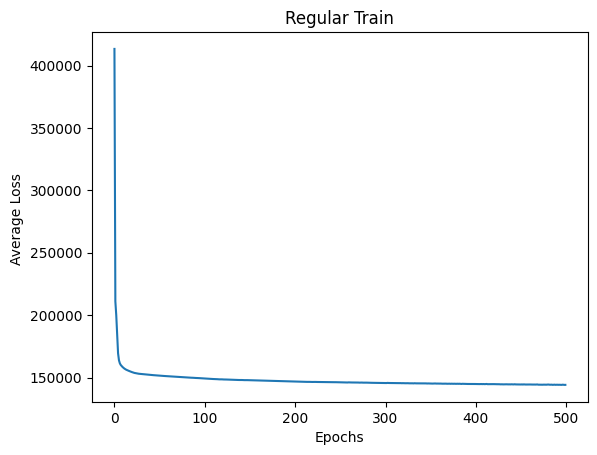

144144.02585490167


In [11]:
plt.plot(regular_train_loss)
plt.title("Regular Train")
plt.xlabel("Epochs")
plt.ylabel("Average Loss ")
plt.show()
print(regular_train_loss[-1])

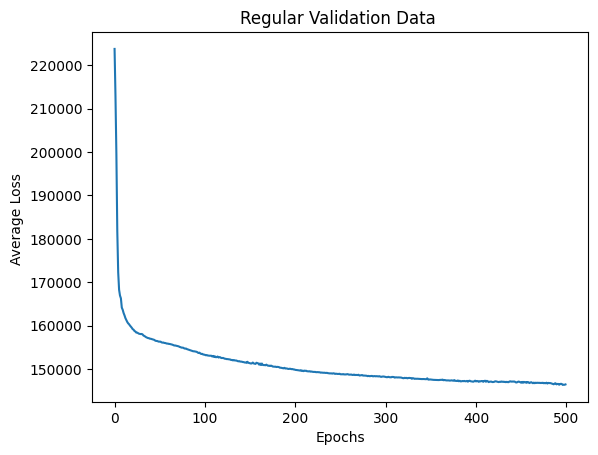

146410.60966415107


In [12]:
plt.plot(regular_test_loss)
plt.title("Regular Validation Data ")
plt.xlabel("Epochs")
plt.ylabel("Average Loss ")
plt.show()
print(regular_test_loss[-1])

## PCA and  Regular Neural Network  

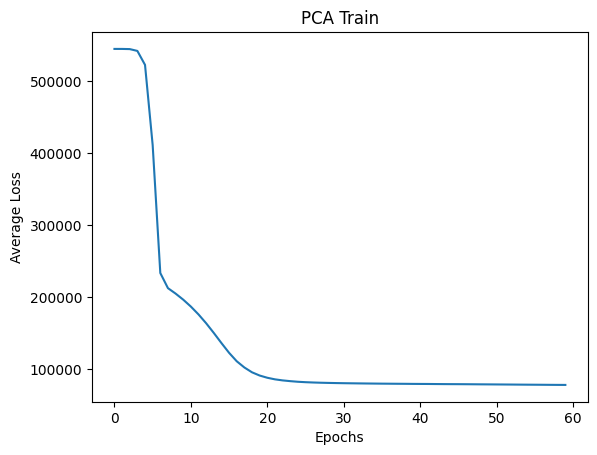

78211.1141736553


In [13]:
plt.plot(pca_train_loss)
plt.title("PCA Train")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(pca_train_loss[-1])

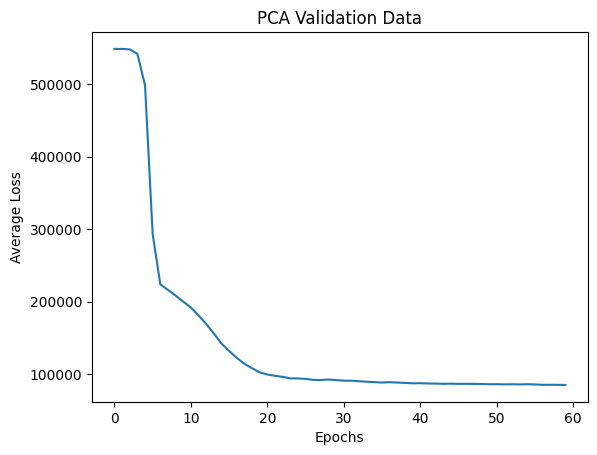

84856.68404825931


In [14]:
plt.plot(pca_test_loss)
plt.title("PCA Validation Data")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(pca_test_loss[-1])

## Standardized Data and Neural Network     

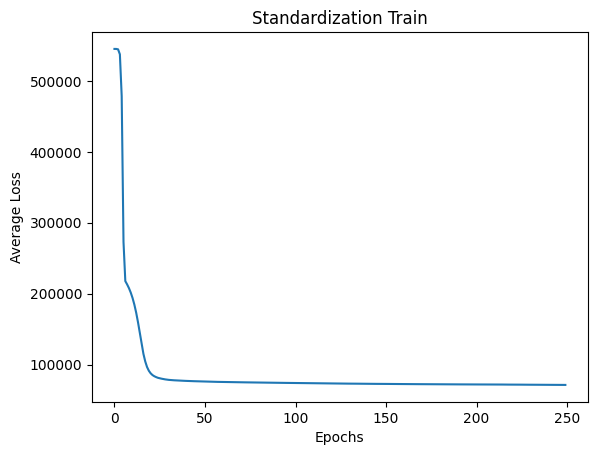

71436.93970503181


In [15]:
plt.plot(stan_train_loss)
plt.title("Standardization Train")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(stan_train_loss[-1])

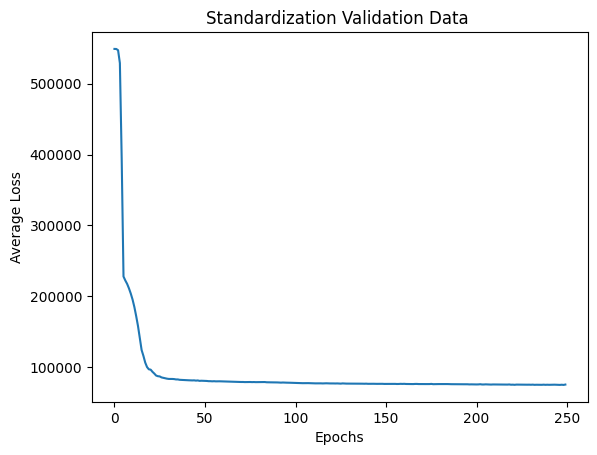

75676.96994997686


In [16]:
plt.plot(stan_test_loss)
plt.title("Standardization Validation Data ")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(stan_test_loss[-1])

## Viewing the Results

The code below will allow you to see the predicted price, actual price, and error for each house in the test dataset. We will use the absolute Loss.

In [17]:
criterion = nn.SmoothL1Loss()
limit = 9

In [18]:
d_test = data(regular=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)

for i, (x, y) in enumerate(test_loader):
    RegularModel.eval()
    z = RegularModel(x)
    loss = criterion(z, y)
    print(i)
    print('Predicted: ',z.item())
    print('Actual: ', y.item())
    print('Loss: ', loss.item())
    if (i == limit):
        break

0
Predicted:  607410.1875
Actual:  459000.0
Loss:  148409.6875
1
Predicted:  339294.1875
Actual:  445000.0
Loss:  105705.3125
2
Predicted:  688367.25
Actual:  1057000.0
Loss:  368632.25
3
Predicted:  505426.46875
Actual:  732350.0
Loss:  226923.03125
4
Predicted:  257455.5625
Actual:  235000.0
Loss:  22455.0625
5
Predicted:  523983.5625
Actual:  555000.0
Loss:  31015.9375
6
Predicted:  566012.9375
Actual:  365000.0
Loss:  201012.4375
7
Predicted:  879227.6875
Actual:  685000.0
Loss:  194227.1875
8
Predicted:  470155.1875
Actual:  525000.0
Loss:  54844.3125
9
Predicted:  497320.15625
Actual:  449950.0
Loss:  47369.65625


In [19]:
d_test = data(pca=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)

for i, (x, y) in enumerate(test_loader):
    PCAModel.eval()
    z = PCAModel(x)
    loss = criterion(z, y)
    print(i)
    print('Predicted: ',z.item())
    print('Actual: ', y.item())
    print('Loss: ', loss.item())
    if (i == limit):
        break

0
Predicted:  466872.625
Actual:  459000.0
Loss:  7872.125
1
Predicted:  414248.4375
Actual:  445000.0
Loss:  30751.0625
2
Predicted:  717322.375
Actual:  1057000.0
Loss:  339677.125
3
Predicted:  777280.0625
Actual:  732350.0
Loss:  44929.5625
4
Predicted:  245080.078125
Actual:  235000.0
Loss:  10079.578125
5
Predicted:  677329.8125
Actual:  555000.0
Loss:  122329.3125
6
Predicted:  419703.90625
Actual:  365000.0
Loss:  54703.40625
7
Predicted:  707194.0625
Actual:  685000.0
Loss:  22193.5625
8
Predicted:  537246.75
Actual:  525000.0
Loss:  12246.25
9
Predicted:  456553.125
Actual:  449950.0
Loss:  6602.625


In [20]:
d_test = data(standard=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)

for i, (x, y) in enumerate(test_loader):
    StandardModel.eval()
    z = StandardModel(x)
    loss = criterion(z, y)
    print(i)
    print('Predicted: ',z.item())
    print('Actual: ', y.item())
    print('Loss: ', loss.item())
    if (i == limit):
        break

0
Predicted:  476262.90625
Actual:  459000.0
Loss:  17262.40625
1
Predicted:  419586.875
Actual:  445000.0
Loss:  25412.625
2
Predicted:  688893.75
Actual:  1057000.0
Loss:  368105.75
3
Predicted:  709276.6875
Actual:  732350.0
Loss:  23072.8125
4
Predicted:  246218.28125
Actual:  235000.0
Loss:  11217.78125
5
Predicted:  612167.25
Actual:  555000.0
Loss:  57166.75
6
Predicted:  389067.78125
Actual:  365000.0
Loss:  24067.28125
7
Predicted:  732669.5
Actual:  685000.0
Loss:  47669.0
8
Predicted:  569164.375
Actual:  525000.0
Loss:  44163.875
9
Predicted:  425183.6875
Actual:  449950.0
Loss:  24765.8125


<h2>About the Authors:</h2> 
<p><a>Azim Hirjani</a></p>
<p><a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.</p>

Copyright &copy; 2020 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.